In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as stats
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths to Images and Masks
images_path = '/content/drive/MyDrive/Data_Analysis_using_python/flood_sample/images'
masks_path = '/content/drive/MyDrive/Data_Analysis_using_python/flood_sample/masks'

In [ ]:
# Image Size
IMG_SIZE = 256

In [ ]:
# Load Images & Masks
images, masks = [], []
for img_name in sorted(os.listdir(images_path)):
    img_path = os.path.join(images_path, img_name)
    mask_path = os.path.join(masks_path, img_name.replace('.jpg', '.png'))

    if not os.path.exists(mask_path):
        continue

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        continue

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = np.mean(mask) > 0.5  # Convert to binary label (flooded/not flooded)

    images.append(image)
    masks.append(mask)

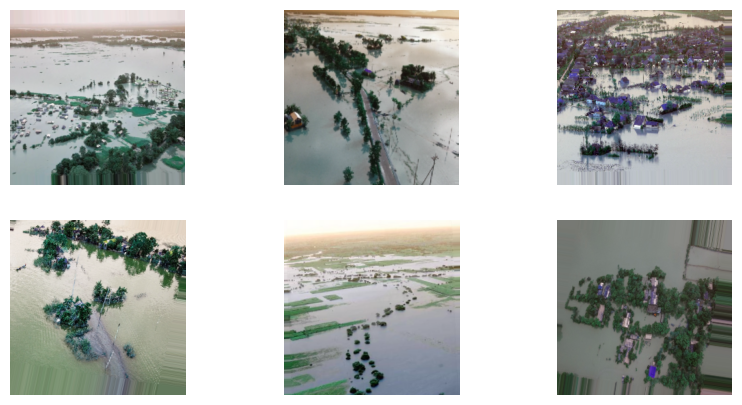

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [ ]:
# Convert to NumPy arrays
images = np.array(images)
masks = np.array(masks, dtype=np.float32)

In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# CNN Model
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Compile Model
cnn_model = build_cnn()
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.6510 - loss: 2.6835 - val_accuracy: 0.6724 - val_loss: 1.1218
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7169 - loss: 0.6545 - val_accuracy: 0.6724 - val_loss: 0.5762
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6466 - loss: 0.6100 - val_accuracy: 0.7241 - val_loss: 0.5298
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7175 - loss: 0.5367 - val_accuracy: 0.6724 - val_loss: 0.6383
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6920 - loss: 0.5895 - val_accuracy: 0.7241 - val_loss: 0.5182
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8445 - loss: 0.3411 - val_accuracy: 0.7759 - val_loss: 0.4749
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9122 - loss: 0.2469 - val_accuracy: 0.7586 - val_loss: 0.5372
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8734 - loss: 0.3052 - val_accuracy: 0.6379 - 

In [ ]:
# Predictions
predictions = (cnn_model.predict(X_val) > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step


In [ ]:
# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

Confusion Matrix:
[[33  6]
 [ 9 10]]


In [ ]:
print("Classification Report:")
print(classification_report(y_val, predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.81        39
         1.0       0.62      0.53      0.57        19

    accuracy                           0.74        58
   macro avg       0.71      0.69      0.69        58
weighted avg       0.73      0.74      0.74        58



#**Balancing DataSet by using Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Data Augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen.fit(X_train)

In [ ]:
# Class Weights
class_weights = {0: 1.0, 1: 3.0}  # Adjust weight to balance classes

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Augmented Training Generator
train_generator = image_datagen.flow(X_train, y_train, batch_size=16, seed=42)

In [ ]:
# Train Model
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_data=(X_val, y_val),
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

# Predictions and Evaluation
predictions = (cnn_model.predict(X_val) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 642ms/step - accuracy: 0.5631 - loss: 4.1461 - val_accuracy: 0.3947 - val_loss: 1.0679
Epoch 2/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4375 - loss: 1.2212

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4375 - loss: 1.2212 - val_accuracy: 0.3947 - val_loss: 0.9179
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.5246 - loss: 1.1803 - val_accuracy: 0.3947 - val_loss: 0.9638
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5000 - loss: 1.0675 - val_accuracy: 0.3947 - val_loss: 0.9065
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.5127 - loss: 1.1286 - val_accuracy: 0.3947 - val_loss: 1.0443
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3750 - loss: 1.2082 - val_accuracy: 0.3947 - val_loss: 1.0558
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.5515 - loss: 1.0236 - val_accuracy: 0.4211 - val_loss: 0.7457
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - loss: 1.0358 - val_accuracy: 0.3947 - val_loss: 0.9890
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5778 - loss: 0.9801 - val_accuracy: 0.3947 - val_loss: 0.9139
Epoch 1

In [ ]:
# Evaluate model
predictions = (cnn_model.predict(X_val) > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion Matrix:
[[ 1 22]
 [ 0 15]]


In [ ]:
print("Classification Report:")
print(classification_report(y_val, predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.04      0.08        23
         1.0       0.41      1.00      0.58        15

    accuracy                           0.42        38
   macro avg       0.70      0.52      0.33        38
weighted avg       0.77      0.42      0.28        38



#**Tests**

In [ ]:
# 1. **P-Test**: Test if the mean pixel intensity of flooded vs non-flooded images is significantly different.
flooded_pixels = X_val[y_val == 1].reshape(-1, IMG_SIZE * IMG_SIZE * 3)  # Flatten the flooded images
non_flooded_pixels = X_val[y_val == 0].reshape(-1, IMG_SIZE * IMG_SIZE * 3)  # Flatten the non-flooded images

# Perform P-Test (this is a simplified example, assuming we have a null hypothesis that the pixel means are equal)
p_value = stats.ttest_ind(flooded_pixels.mean(axis=1), non_flooded_pixels.mean(axis=1)).pvalue
print(f"P-Test p-value: {p_value}")

P-Test p-value: 0.15059292420177026


In [ ]:
# 2. **T-Test**: Compare the means of pixel intensities between flooded and non-flooded images.
t_stat, p_value_t = stats.ttest_ind(flooded_pixels.mean(axis=1), non_flooded_pixels.mean(axis=1))
print(f"T-Test p-value: {p_value_t}")

T-Test p-value: 0.15059292420177026


In [ ]:
# 3. **Z-Test**: Assuming large sample size, perform Z-Test for pixel intensity means.
flooded_mean = flooded_pixels.mean(axis=1).mean()
non_flooded_mean = non_flooded_pixels.mean(axis=1).mean()

flooded_std = flooded_pixels.std(axis=1).mean()
non_flooded_std = non_flooded_pixels.std(axis=1).mean()

# Z-test formula: (X1 - X2) / sqrt((std1^2 / n1) + (std2^2 / n2))
z_stat = (flooded_mean - non_flooded_mean) / np.sqrt((flooded_std**2 / len(flooded_pixels)) + (non_flooded_std**2 / len(non_flooded_pixels)))
print(f"Z-Test Statistic: {z_stat}")

Z-Test Statistic: 0.6188466030637658


In [ ]:
# 4. **ANOVA Test**: If you had more than two categories (e.g., flooded, non-flooded, partially flooded), ANOVA can be applied.
# For simplicity, this example uses only flooded vs non-flooded.
# Perform ANOVA (One-Way Analysis of Variance)
anova_stat, p_value_anova = stats.f_oneway(flooded_pixels.mean(axis=1), non_flooded_pixels.mean(axis=1))
print(f"ANOVA p-value: {p_value_anova}")

ANOVA p-value: 0.15059292420177062


In [ ]:
# 5. **Type 1 and Type 2 Errors**: Based on the confusion matrix.
cm = confusion_matrix(y_val, predictions)  # Generate confusion matrix
TN, FP, FN, TP = cm.ravel()  # Extract the confusion matrix values
type_1_error = FP / (FP + TN)  # False Positive Rate
type_2_error = FN / (FN + TP)  # False Negative Rate

print(f"Type 1 Error (False Positive Rate): {type_1_error}")
print(f"Type 2 Error (False Negative Rate): {type_2_error}")

Type 1 Error (False Positive Rate): 0.9565217391304348
Type 2 Error (False Negative Rate): 0.0
